In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation


C:\Users\Maln\AppData\Roaming\Python\Python37\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.7) or chardet (4.0.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
sales = pd.read_csv('../data/calgary_resales/total_sales.csv',index_col=0)
prices = pd.read_csv('../data/calgary_resales/total_avg_price.csv',index_col=0)
listings = pd.read_csv('../data/calgary_resales/total_active_listings.csv',index_col=0)

sa_price = pd.read_csv('../data/pareto/acapricna_q.csv',index_col=0)
sa_sales = pd.read_csv('../data/pareto/acasaluna_q.csv',index_col=0)
sa_sfd_starts = pd.read_csv('../data/pareto/acassmura_q.csv',index_col=0)
sa_multi_starts = pd.read_csv('../data/pareto/acasmmura_q.csv',index_col=0)
sa_tot_starts = pd.read_csv('../data/pareto/acastmura_q.csv',index_col=0)


In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))
sales_data = scaler.fit_transform(sales.values)

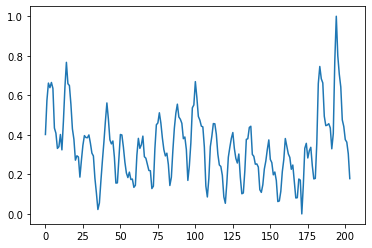

In [4]:
plt.plot(sales_data)


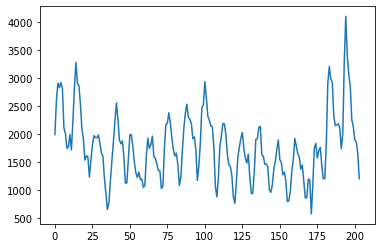

In [5]:
plt.plot(sales.values)

In [6]:
train_size = int(len(sales_data) * 0.75)
test_size = len(sales_data) - train_size
train, test = sales_data[0:train_size,:], sales_data[train_size:len(sales_data),:]
print(len(train), len(test))

153 51


In [7]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [8]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [9]:
trainX.shape

(151, 1)

In [10]:
model = Sequential()
model.add(LSTM(100, input_shape=(1,look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
151/151 - 1s - loss: 0.0407 - 1s/epoch - 10ms/step
Epoch 2/100
151/151 - 0s - loss: 0.0123 - 117ms/epoch - 775us/step
Epoch 3/100
151/151 - 0s - loss: 0.0100 - 115ms/epoch - 762us/step
Epoch 4/100
151/151 - 0s - loss: 0.0083 - 115ms/epoch - 762us/step
Epoch 5/100
151/151 - 0s - loss: 0.0071 - 119ms/epoch - 788us/step
Epoch 6/100
151/151 - 0s - loss: 0.0067 - 118ms/epoch - 781us/step
Epoch 7/100
151/151 - 0s - loss: 0.0066 - 117ms/epoch - 775us/step
Epoch 8/100
151/151 - 0s - loss: 0.0065 - 116ms/epoch - 768us/step
Epoch 9/100
151/151 - 0s - loss: 0.0064 - 119ms/epoch - 788us/step
Epoch 10/100
151/151 - 0s - loss: 0.0066 - 118ms/epoch - 778us/step
Epoch 11/100
151/151 - 0s - loss: 0.0067 - 119ms/epoch - 788us/step
Epoch 12/100
151/151 - 0s - loss: 0.0067 - 116ms/epoch - 766us/step
Epoch 13/100
151/151 - 0s - loss: 0.0064 - 122ms/epoch - 805us/step
Epoch 14/100
151/151 - 0s - loss: 0.0065 - 120ms/epoch - 796us/step
Epoch 15/100
151/151 - 0s - loss: 0.0062 - 120ms/epoch - 795u

In [11]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

2/2 [==============================] - 0s 2ms/step
Train Score: 276.23 RMSE
Test Score: 390.58 RMSE


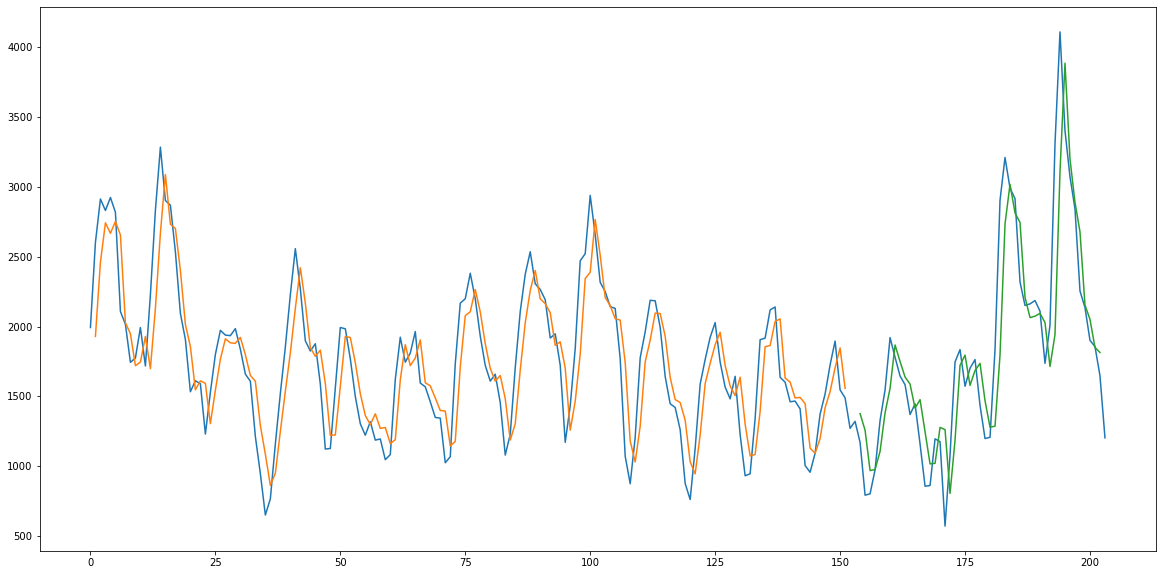

In [13]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(sales_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(sales_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(sales_data)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(sales_data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

plt.show()

In [14]:
tot_vol =pd.read_csv('../data/calgary_resales/total_volume.csv',index_col=0)
tot_vol.index = pd.to_datetime(tot_vol.index)

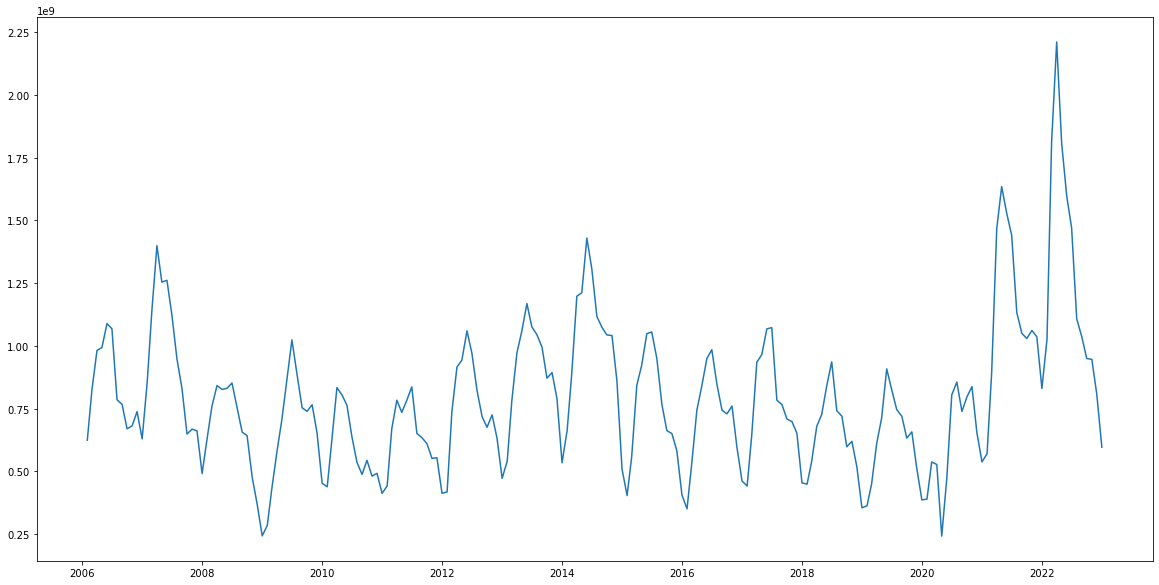

In [15]:
plt.figure(figsize=(20,10))
plt.plot(tot_vol)

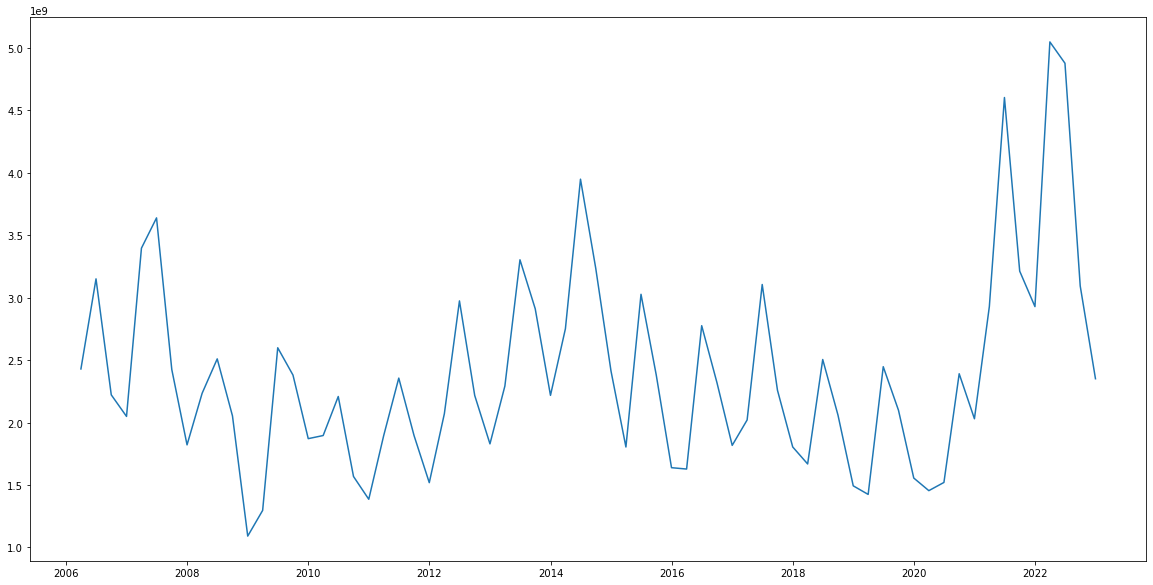

In [16]:
plt.figure(figsize=(20,10))

plt.plot(tot_vol.resample('Q').sum())

In [30]:
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order
from statsmodels.tsa.seasonal import STL
plt.rc("figure", figsize=(16, 10))

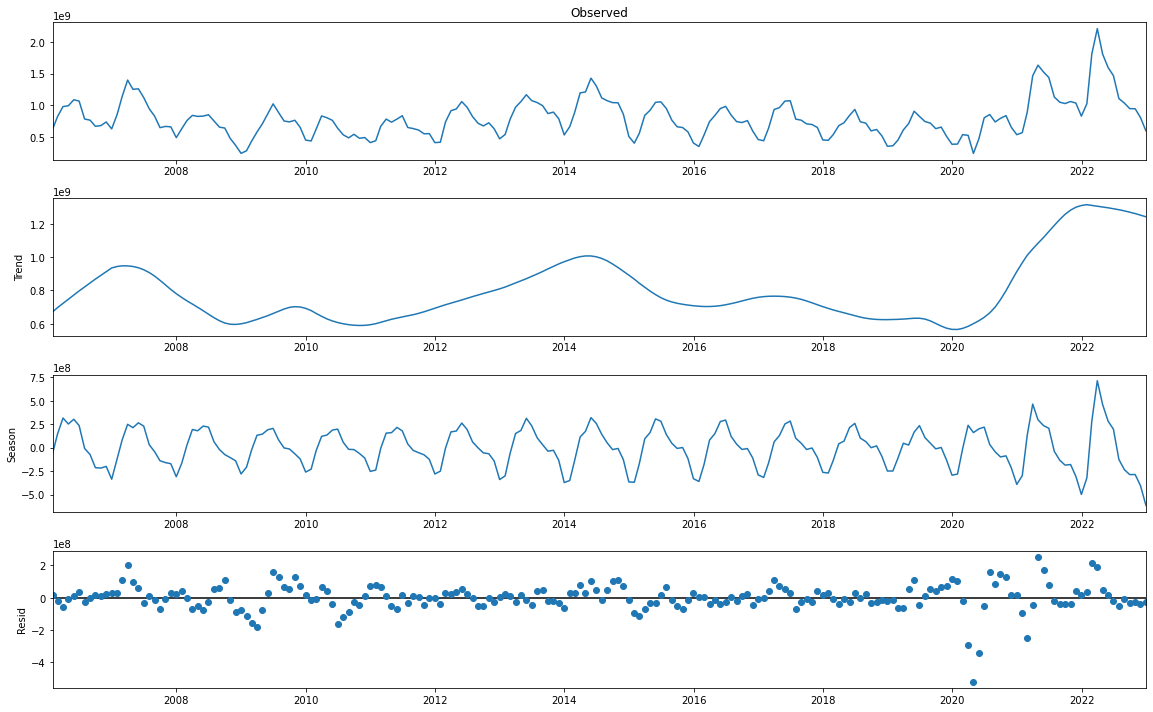

In [18]:
stl = STL(tot_vol, period = 12 )
res=stl.fit()
fig=res.plot()

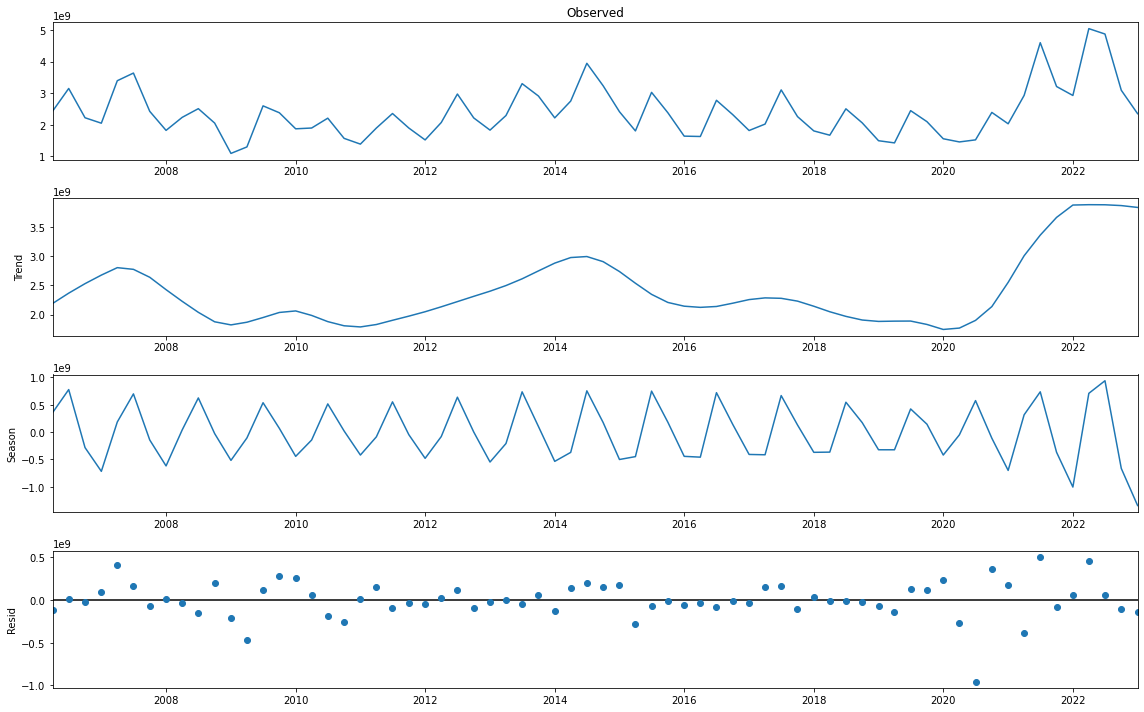

In [19]:
stl = STL(tot_vol.resample('Q').sum(), period = 4 )
res=stl.fit()
fig=res.plot()

In [20]:
nat_var = pd.read_excel('../data/hmo_2023_variables.xlsx',sheet_name='national',engine='openpyxl',index_col=0)
prov_var=pd.read_excel('../data/hmo_2023_variables.xlsx',sheet_name='provincial',engine='openpyxl',index_col=0)
covid = pd.read_excel('../data/hmo_2023_variables.xlsx',sheet_name='covid_dummy',engine='openpyxl',index_col=0)
wti = pd.read_excel('../data/hmo_2023_variables.xlsx',sheet_name='wti',engine='openpyxl',index_col=0)


nat_var.index = nat_var.index.str.replace(' ','')
nat_var.index = nat_var.index.rename('Date')
nat_var.index = pd.PeriodIndex(nat_var.index,freq='Q').to_timestamp()

prov_var.index = prov_var.index.rename('Date')
prov_var.index = pd.PeriodIndex(prov_var.index,freq='Q').to_timestamp()


covid.index = covid.index.str.replace(' ','')
covid.index = covid.index.rename('Date')
covid.index = pd.PeriodIndex(covid.index,freq='Q').to_timestamp()

wti.index=wti.index.str.replace(' ','')
wti.index = wti.index.rename('Date')
wti.index = pd.PeriodIndex(wti.index,freq='Q').to_timestamp()

In [21]:
prov_var = prov_var.join(nat_var)
prov_var = prov_var.join(covid)
prov_var = prov_var.join(wti)

In [22]:
prov_var['1988':'2022']

,gdp_AB_2023,gdp_AB_2023_alt,unemp_AB_2023,unemp_AB_2023_alt,emp_AB_2023,emp_AB_2023_alt,cpi_AB_2023,cpi_AB_2023_alt,cpiyoy_AB_2023,cpiyoy_AB_2023_alt,policy_rate_base,policy_rate_alt,"Interest rate, 10-Year Benchmark Bond Yield",5_year_mortgage_base,5_year_mortgage_alt,COVID-19,Long COVID,WTI_base,WTI_lower,WTI_upper
Date,,,,,,,,,,,,,,,,,,,,
1988-01-01,143214.392000,143214.392000,8.266667,8.266667,1.215783e+03,1.215783e+03,67.536693,67.536693,0.040768,0.040768,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
1988-04-01,145540.498000,145540.498000,7.866667,7.866667,1.220227e+03,1.220227e+03,68.005108,68.005108,0.031137,0.031137,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
1988-07-01,144768.108000,144768.108000,7.900000,7.900000,1.223683e+03,1.223683e+03,68.145014,68.145014,0.019949,0.019949,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
1988-10-01,143141.003000,143141.003000,7.900000,7.900000,1.231610e+03,1.231610e+03,68.519212,68.519212,0.017447,0.017447,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
1989-01-01,146741.200000,146741.200000,7.466667,7.466667,1.243675e+03,1.243675e+03,69.220147,69.220147,0.024927,0.024927,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01,85228.393111,85230.664006,7.132942,7.143528,2.295818e+06,2.295819e+06,152.019312,152.013461,0.044714,0.044674,0.250000,0.250000,1.577258,3.380000,3.380000,0.0,0.0,77.446667,77.446667,77.446667
2022-01-01,85964.668220,85966.650608,6.419204,6.428459,2.321075e+06,2.321071e+06,154.648125,154.642173,0.053668,0.053571,0.332031,0.332031,1.934355,3.596667,3.596667,0.0,0.0,94.453333,94.453333,94.453333
2022-04-01,86818.487112,86819.489920,5.567215,5.571800,2.348839e+06,2.348834e+06,158.771093,158.767437,0.071064,0.071031,1.092308,1.092308,2.989048,4.623333,4.623333,0.0,0.0,108.723333,108.723333,108.723333


In [24]:
df = prov_var.join(sa_sales)

In [27]:
df = df.join(sa_price)
df = df.join(sa_sfd_starts)
df = df.join(sa_multi_starts)
df = df.join(sa_tot_starts)


In [41]:
df['1996':'2022']

,gdp_AB_2023,gdp_AB_2023_alt,unemp_AB_2023,unemp_AB_2023_alt,emp_AB_2023,emp_AB_2023_alt,cpi_AB_2023,cpi_AB_2023_alt,cpiyoy_AB_2023,cpiyoy_AB_2023_alt,...,COVID-19,Long COVID,WTI_base,WTI_lower,WTI_upper,ACASALUNA_Q,ACAPRICNA_Q,ACASSMURA_Q,ACASMMURA_Q,ACASTMURA_Q
Date,,,,,,,,,,,,,,,,,,,,,
1996-01-01,178136.970000,178136.970000,7.366667,7.366667,1.392461e+03,1.392461e+03,85.542393,85.542393,0.018310,0.018310,...,0.0,0.0,19.760000,19.760000,19.760000,3983.0,133131.0,4.451,1.097,5.548
1996-04-01,181053.429000,181053.429000,6.966667,6.966667,1.401748e+03,1.401748e+03,86.256546,86.256546,0.022193,0.022193,...,0.0,0.0,21.696667,21.696667,21.696667,4200.0,135099.0,5.986,0.981,6.967
1996-07-01,182231.757000,182231.757000,6.733333,6.733333,1.409710e+03,1.409710e+03,86.644273,86.644273,0.023742,0.023742,...,0.0,0.0,22.390000,22.390000,22.390000,4287.0,133805.0,6.678,1.299,7.977
1996-10-01,184725.845000,184725.845000,6.466667,6.466667,1.415015e+03,1.415015e+03,86.972212,86.972212,0.022391,0.022391,...,0.0,0.0,24.606667,24.606667,24.606667,5296.0,136097.0,5.979,1.468,7.447
1997-01-01,192243.881000,192243.881000,6.366667,6.366667,1.429138e+03,1.429138e+03,88.132377,88.132377,0.030277,0.030277,...,0.0,0.0,22.760000,22.760000,22.760000,5436.0,139000.0,9.556,2.691,12.247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01,85228.393111,85230.664006,7.132942,7.143528,2.295818e+06,2.295819e+06,152.019312,152.013461,0.044714,0.044674,...,0.0,0.0,77.446667,77.446667,77.446667,10262.0,504984.0,5.626,12.492,18.118
2022-01-01,85964.668220,85966.650608,6.419204,6.428459,2.321075e+06,2.321071e+06,154.648125,154.642173,0.053668,0.053571,...,0.0,0.0,94.453333,94.453333,94.453333,12947.0,541178.0,5.571,7.436,13.007
2022-04-01,86818.487112,86819.489920,5.567215,5.571800,2.348839e+06,2.348834e+06,158.771093,158.767437,0.071064,0.071031,...,0.0,0.0,108.723333,108.723333,108.723333,9625.0,527825.0,6.172,13.680,19.852


In [31]:
df.columns

Index(['gdp_AB_2023', 'gdp_AB_2023_alt', 'unemp_AB_2023', 'unemp_AB_2023_alt',
       'emp_AB_2023', 'emp_AB_2023_alt', 'cpi_AB_2023', 'cpi_AB_2023_alt',
       'cpiyoy_AB_2023', 'cpiyoy_AB_2023_alt', 'policy_rate_base',
       'policy_rate_alt', 'Interest rate, 10-Year Benchmark Bond Yield',
       '5_year_mortgage_base', '5_year_mortgage_alt', 'COVID-19', 'Long COVID',
       'WTI_base', 'WTI_lower', 'WTI_upper', 'ACASALUNA_Q', 'ACAPRICNA_Q',
       'ACASSMURA_Q', 'ACASMMURA_Q', 'ACASTMURA_Q'],
      dtype='object')

In [82]:
sel_res = ardl_select_order(df['ACASALUNA_Q']['1996':'2022'],4,df[['unemp_AB_2023','WTI_upper','5_year_mortgage_base']]['1996':'2022'],ic='aic',trend='c',maxorder=12)

In [83]:
print(f"The optimal order is: {sel_res.model.ardl_order}")

The optimal order is: (1, 9, 1, 2)


In [84]:
res = sel_res.model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:            ACASALUNA_Q   No. Observations:                  108
Model:               ARDL(1, 9, 1, 2)   Log Likelihood                -824.889
Method:               Conditional MLE   S.D. of innovations            539.316
Date:                Thu, 23 Feb 2023   AIC                           1685.778
Time:                        00:59:02   BIC                           1733.888
Sample:                    04-01-1998   HQIC                          1705.281
                         - 10-01-2022                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     355.8380   1074.303      0.331      0.741   -1778.452    2490.128
ACASALUNA_Q.L1              0.9317      0.059     15.731      0.000       0.814       1.049
unemp_AB_2023.L0         -277.5807     87.468     -3.174      0.002    -451.350    -103.811
unemp_AB_2023.L1          432.6676    113.524      3.811      0.000     207.132     658.203
unemp_AB_2023.L2         -160.4074    109.539     -1.464      0.147    -378.026      57.212
unemp_AB_2023.L3          -53.6662    109.070     -0.492      0.624    -270.353     163.021
unemp_AB_2023.L4           57.3609    108.365      0.529      0.598    -157.924     272.646
unemp_AB_2023.L5         -150.8448    108.485     -1.390      0.168    -366.370      64.681
unemp_AB_2023.L6          185.8872    109.129      1.703      0.092     -30.917     402.691
unemp_AB_2023.L7          252.3559    109.094      2.313      0.023      35.622     469.090
unemp_AB_2023.L8         -584.5982    111.866     -5.226      0.000    -806.840    -362.356
unemp_AB_2023.L9          382.5539     87.851      4.355      0.000     208.023     557.085
WTI_upper.L0               26.8351      6.821      3.934      0.000      13.284      40.387
WTI_upper.L1              -27.9394      6.879     -4.062      0.000     -41.605     -14.274
5_year_mortgage_base.L0  -799.6392    268.026     -2.983      0.004   -1332.119    -267.159
5_year_mortgage_base.L1  -122.6947    398.118     -0.308      0.759    -913.626     668.237
5_year_mortgage_base.L2   860.2998    260.187      3.306      0.001     343.392    1377.207
===========================================================================================
"""

<AxesSubplot:>

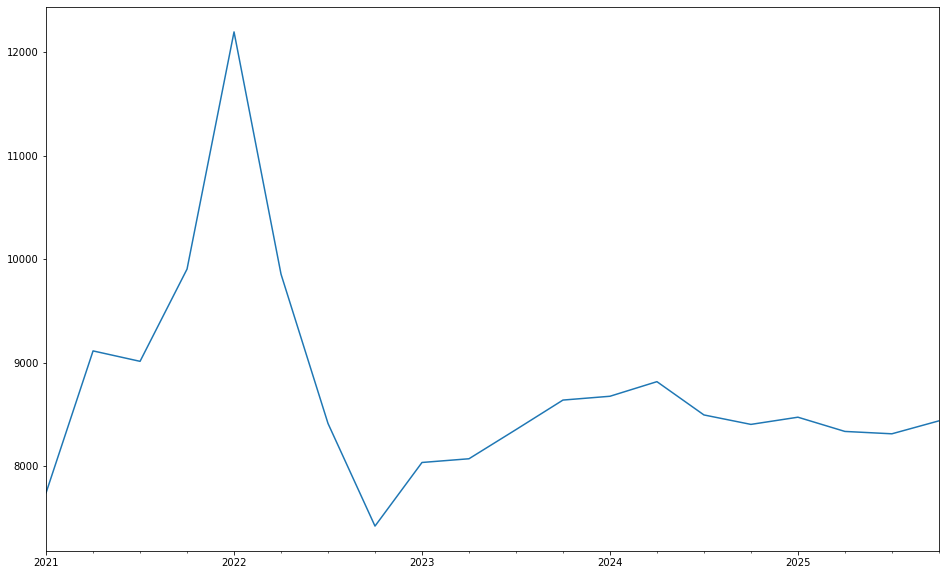

In [78]:
res.predict(start=100,end=119, exog_oos=df[['unemp_AB_2023','WTI_upper','5_year_mortgage_base']]['2023':'2025']).plot()

In [85]:
res.predict(start=100,end=119, exog_oos=df[['unemp_AB_2023','WTI_upper','5_year_mortgage_base']]['2023':'2025'])

2021-01-01     7745.674264
2021-04-01     9116.085404
2021-07-01     9015.415664
2021-10-01     9906.710219
2022-01-01    12198.043055
2022-04-01     9857.593745
2022-07-01     8414.992656
2022-10-01     7423.608125
2023-01-01     8038.219920
2023-04-01     8074.094284
2023-07-01     8355.736788
2023-10-01     8641.149677
2024-01-01     8677.884314
2024-04-01     8818.968453
2024-07-01     8497.452926
2024-10-01     8406.136219
2025-01-01     8475.637001
2025-04-01     8338.139101
2025-07-01     8315.240173
2025-10-01     8440.228721
Freq: QS-OCT, dtype: float64

In [86]:
sel_res = ardl_select_order(df['ACASALUNA_Q']['1996':'2022'],4,df[['unemp_AB_2023','WTI_base','5_year_mortgage_base']]['1996':'2022'],ic='aic',trend='c',maxorder=12)

In [87]:
res = sel_res.model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:            ACASALUNA_Q   No. Observations:                  108
Model:               ARDL(1, 9, 1, 2)   Log Likelihood                -824.889
Method:               Conditional MLE   S.D. of innovations            539.316
Date:                Thu, 23 Feb 2023   AIC                           1685.778
Time:                        00:59:58   BIC                           1733.888
Sample:                    04-01-1998   HQIC                          1705.281
                         - 10-01-2022                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     355.8380   1074.303      0.331      0.741   -1778.452    2490.128
ACASALUNA_Q.L1              0.9317      0.059     15.731      0.000       0.814       1.049
unemp_AB_2023.L0         -277.5807     87.468     -3.174      0.002    -451.350    -103.811
unemp_AB_2023.L1          432.6676    113.524      3.811      0.000     207.132     658.203
unemp_AB_2023.L2         -160.4074    109.539     -1.464      0.147    -378.026      57.212
unemp_AB_2023.L3          -53.6662    109.070     -0.492      0.624    -270.353     163.021
unemp_AB_2023.L4           57.3609    108.365      0.529      0.598    -157.924     272.646
unemp_AB_2023.L5         -150.8448    108.485     -1.390      0.168    -366.370      64.681
unemp_AB_2023.L6          185.8872    109.129      1.703      0.092     -30.917     402.691
unemp_AB_2023.L7          252.3559    109.094      2.313      0.023      35.622     469.090
unemp_AB_2023.L8         -584.5982    111.866     -5.226      0.000    -806.840    -362.356
unemp_AB_2023.L9          382.5539     87.851      4.355      0.000     208.023     557.085
WTI_base.L0                26.8351      6.821      3.934      0.000      13.284      40.387
WTI_base.L1               -27.9394      6.879     -4.062      0.000     -41.605     -14.274
5_year_mortgage_base.L0  -799.6392    268.026     -2.983      0.004   -1332.119    -267.159
5_year_mortgage_base.L1  -122.6947    398.118     -0.308      0.759    -913.626     668.237
5_year_mortgage_base.L2   860.2998    260.187      3.306      0.001     343.392    1377.207
===========================================================================================
"""

<AxesSubplot:>

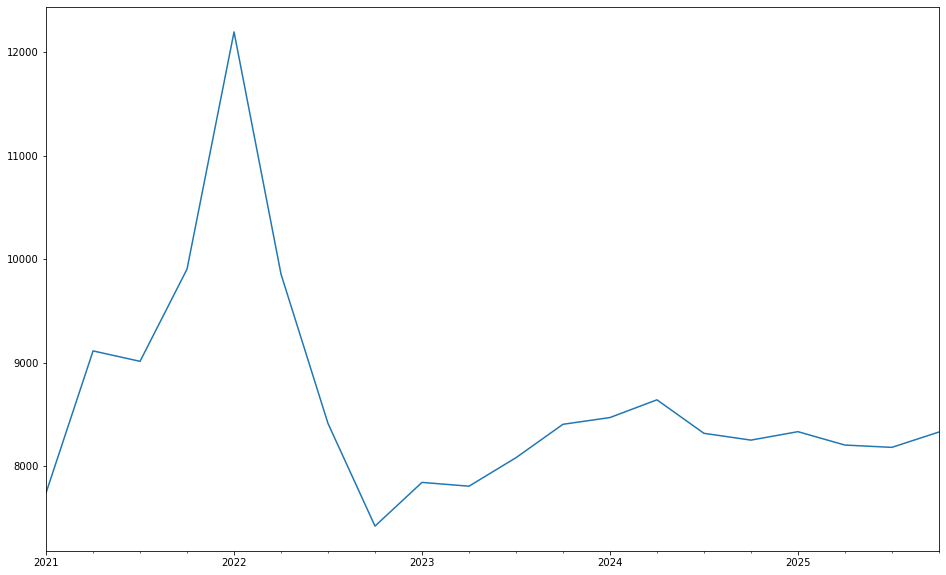

In [89]:
res.predict(start=100,end=119, exog_oos=df[['unemp_AB_2023','WTI_base','5_year_mortgage_base']]['2023':'2025']).plot()

In [90]:
res.predict(start=100,end=119, exog_oos=df[['unemp_AB_2023','WTI_base','5_year_mortgage_base']]['2023':'2025'])

2021-01-01     7745.674264
2021-04-01     9116.085404
2021-07-01     9015.415664
2021-10-01     9906.710219
2022-01-01    12198.043055
2022-04-01     9857.593745
2022-07-01     8414.992656
2022-10-01     7423.608125
2023-01-01     7845.737128
2023-04-01     7809.058956
2023-07-01     8084.344385
2023-10-01     8407.116343
2024-01-01     8472.184509
2024-04-01     8643.524770
2024-07-01     8320.041517
2024-10-01     8254.204706
2025-01-01     8335.866959
2025-04-01     8206.510239
2025-07-01     8184.121711
2025-10-01     8332.301613
Freq: QS-OCT, dtype: float64

In [64]:
df[['emp_AB_2023','unemp_AB_2023','WTI_base','5_year_mortgage_base']]['2023':'2025']

,emp_AB_2023,unemp_AB_2023,WTI_base,5_year_mortgage_base
Date,,,,
2023-01-01,2.367077e+06,5.898860,75.391749,5.796000
2023-04-01,2.356205e+06,6.894211,70.699614,5.751988
2023-07-01,2.348954e+06,7.779017,72.862814,5.707973
2023-10-01,2.349603e+06,8.339072,77.945626,5.663971
2024-01-01,2.351967e+06,8.802481,84.454809,5.620816
2024-04-01,2.362560e+06,8.963991,85.651243,5.577656
2024-07-01,2.375574e+06,9.069967,86.999157,5.534496
2024-10-01,2.392211e+06,8.990127,87.843871,5.491311
2025-01-01,2.413583e+06,8.840621,89.249621,5.448102


In [25]:
tot_vol.resample('Q').sum()

,total_volume
2006-03-31,2.428910e+09
2006-06-30,3.149948e+09
2006-09-30,2.221428e+09
2006-12-31,2.048780e+09
2007-03-31,3.395725e+09
...,...
2021-12-31,2.927857e+09
2022-03-31,5.046941e+09
2022-06-30,4.876090e+09
2022-09-30,3.093077e+09


In [ ]:
history_df=test_df['1988':'2021']
val = np.array(history_df[['avg_price_sa_log_diff']].values,dtype=float)
size = int(len(val)*0.85)
train, test = val[0:size], val[size:len(val)]
history=[x for x in train]
exog = np.array(history_df[['WTI_Base','Interest rate on fixed 5-year mortgages [%]','COVID-19','CPI']].values,dtype=float)
exog_train, exog_test = exog[0:size], exog[size:len(exog)]
exog_train = np.array(exog_train, dtype=float)
predictions = list()
model = SARIMAX(history,order=(1,1,1), seasonal_order=(0,0,0,0),exog=exog_train)
model_fit=model.fit()
output=model_fit.get_forecast(len(test), exog=exog_test)
rmse=math.sqrt(mean_squared_error(test,output.summary_frame()['mean']))
print('RMSE: %.3f' % rmse)
plt.plot(output.summary_frame()['mean'],color='red')
plt.plot(test)